In [1]:
# Imports
import numpy as np
import rasterio
from pyproj import transform
from rasterio.crs import CRS
from rasterio.warp import transform
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

FILEPATH_PREFIX = "downloads/S2A_MSIL2A_20210716T095031_N0301_R079_T34UEF_20210716T120258.SAFE/GRANULE/L2A_T34UEF_A031679_20210716T095359/IMG_DATA/R10m/T34UEF_20210716T095031"
CLUSTER_THRESHOLD = 8000
SHOW_IMAGES = True

In [2]:
# Read data
dataset_band_1 = rasterio.open(FILEPATH_PREFIX + '_B03_10m.jp2')
dataset_band_2 = rasterio.open(FILEPATH_PREFIX + '_B08_10m.jp2')

In [3]:
# Water Mask calculation
image_band_1 = dataset_band_1.read(1)
image_band_2 = dataset_band_2.read(1)
image_band_1_norm = image_band_1 / np.max(np.abs(image_band_1))
image_band_2_norm = image_band_2 / np.max(np.abs(image_band_2))
image_ndwi = (image_band_1_norm - image_band_2_norm) // (image_band_1_norm + image_band_2_norm + np.ones((image_band_1_norm.shape[0], image_band_1_norm.shape[1]))) + np.ones((image_band_1_norm.shape[0], image_band_1_norm.shape[1]))
water_mask = image_ndwi > 0.1

In [4]:
# Clustering
water_indexes = np.transpose(water_mask.nonzero())
clusters = DBSCAN(eps = 5.0, min_samples = 10, algorithm='kd_tree', n_jobs = -1).fit(water_indexes)
unique, counts = np.unique(clusters.labels_, return_counts = True)
cluster_indexes = dict(zip(unique, counts))
cluster_indexes_above_thre = {k: v for k, v in cluster_indexes.items() if v > CLUSTER_THRESHOLD and k != -1}
cluster_mask = [idx in cluster_indexes_above_thre for idx in clusters.labels_]
water_indexes_image_coords = water_indexes[cluster_mask]


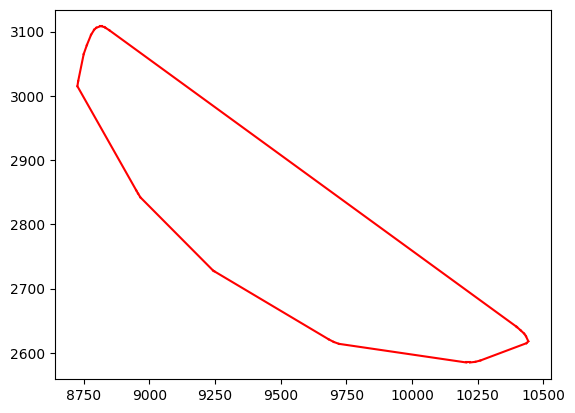

In [5]:
# Geometry
hulls_pixels = []
centroids = []
surface_areas = []

for index in cluster_indexes_above_thre:
    zipped_water_clusters = zip(water_indexes, clusters.labels_)
    pixels_in_cluster = []
    for point, cluster_idx in zipped_water_clusters:
        if cluster_idx == index:
            pixels_in_cluster.append([point[1], point[0]]) 

    pixels_in_cluster = np.array(pixels_in_cluster)

    hull = ConvexHull(pixels_in_cluster)
    hull_pixels = []
    for s in hull.simplices:
        hull_pixels.append([pixels_in_cluster[s, 0], pixels_in_cluster[s, 1]])
    hulls_pixels.append(hull_pixels)

    cx = np.mean(pixels_in_cluster[:, 1])
    cy = np.mean(pixels_in_cluster[:, 0])
    centroids.append([cx, cy])

    surface_area = len(pixels_in_cluster) * 100
    surface_areas.append(surface_area)

if (SHOW_IMAGES):
    for p in hulls_pixels[0]:
        plt.plot(p[0], p[1], 'r-')
    plt.show()

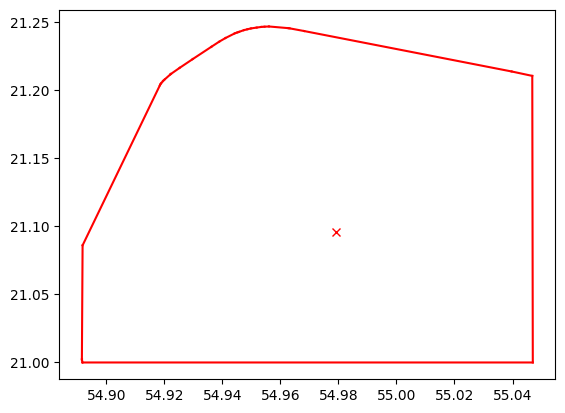

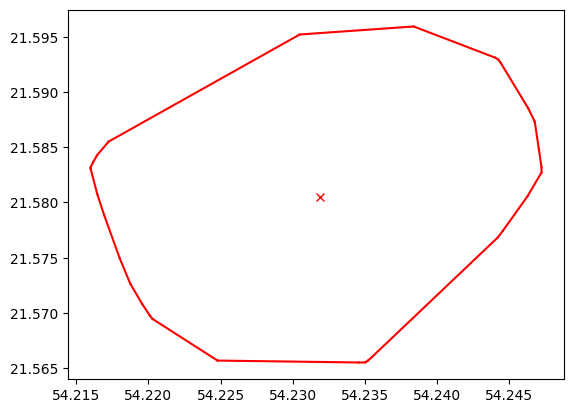

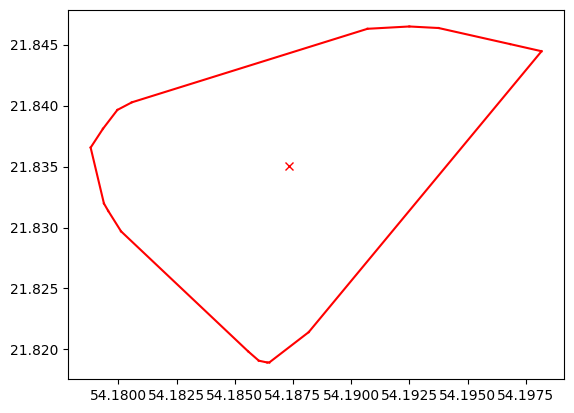

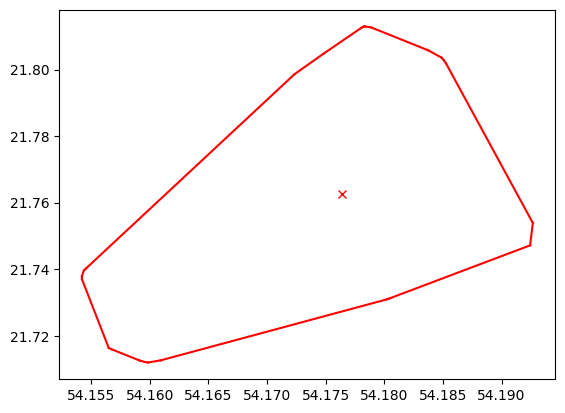

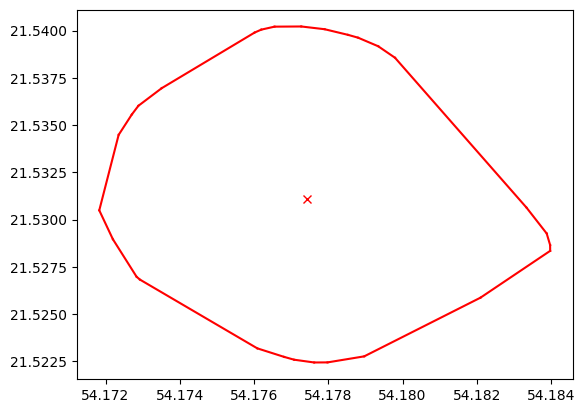

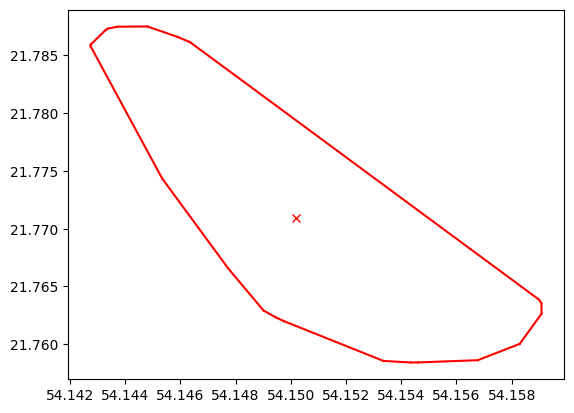

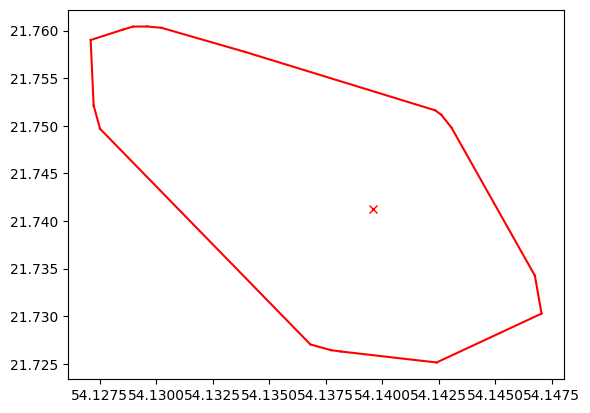

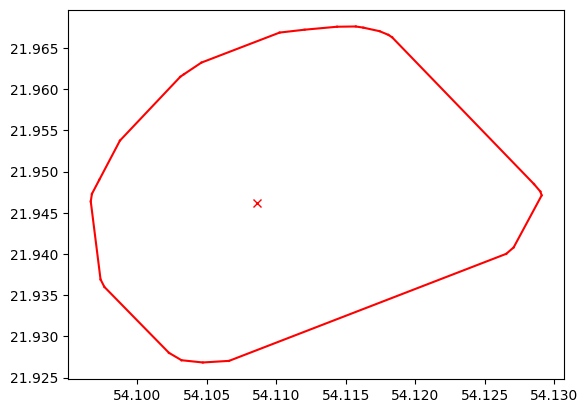

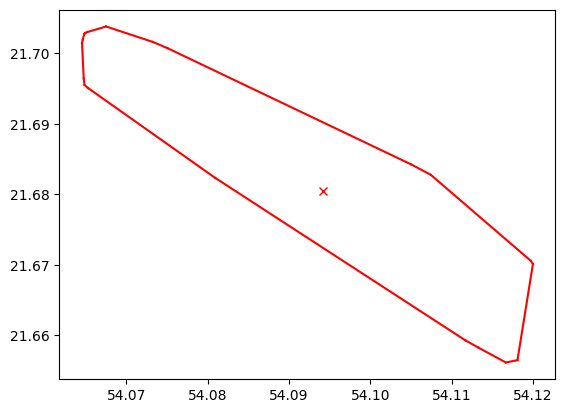

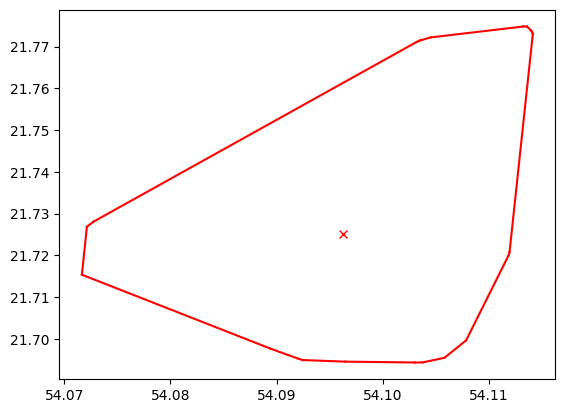

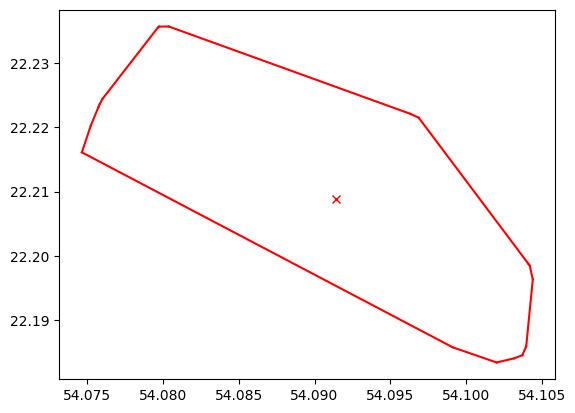

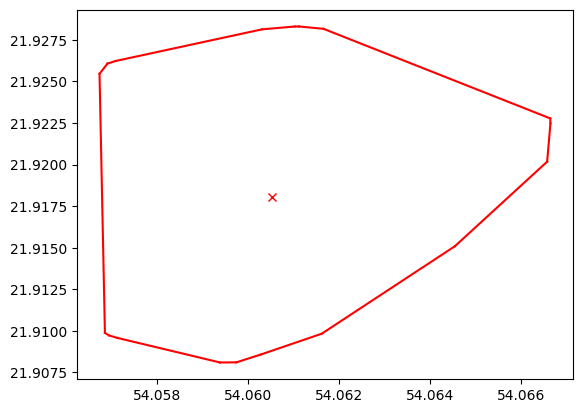

In [6]:
# Real Coords calculation
real_coords_hulls_pixels = []
real_coords_centroids = []

new_crs = CRS.from_epsg(4326)

data_transform = dataset_band_1.transform
move_to_real_coords = lambda water_idx: data_transform * water_idx

for n in hulls_pixels:
    real_coords_hulls_pixels_first = []
    real_coords_hulls_pixels_second = []
    real_coords_hulls_pixels_connected = []

    transformed_hulls_pixels_first = np.array([move_to_real_coords(np.array([xi[0][0], xi[1][0]])) for xi in n])
    for hull_pixels in transformed_hulls_pixels_first:
        real_coords_hull_pixels = transform(dataset_band_2.crs, new_crs, xs=[hull_pixels[0]], ys=[hull_pixels[1]])
        real_coords_hulls_pixels_first.append([real_coords_hull_pixels[1][0], real_coords_hull_pixels[0][0]])

    transformed_hulls_pixels_second = np.array([move_to_real_coords(np.array([xi[0][1], xi[1][1]])) for xi in n])
    for hull_pixels in transformed_hulls_pixels_second:
        real_coords_hull_pixels = transform(dataset_band_2.crs, new_crs, xs=[hull_pixels[0]], ys=[hull_pixels[1]])
        real_coords_hulls_pixels_second.append([real_coords_hull_pixels[1][0], real_coords_hull_pixels[0][0]])

    index = 0
    side = 1 # 1 - first to second, 2 - second to first
    while (len(real_coords_hulls_pixels_connected) < len(real_coords_hulls_pixels_first)):
        if len(real_coords_hulls_pixels_connected) == len(real_coords_hulls_pixels_first) - 1:
            real_coords_hulls_pixels_connected.append(real_coords_hulls_pixels_first[0])
        else:
            if side == 1:
                real_coords_hulls_pixels_connected.append(real_coords_hulls_pixels_first[index])
            else:
                real_coords_hulls_pixels_connected.append(real_coords_hulls_pixels_second[index])


            for i in range(len(real_coords_hulls_pixels_first)):
                if side == 1:
                    if real_coords_hulls_pixels_second[index] == real_coords_hulls_pixels_first[i]:
                        index = i
                        break
                    elif real_coords_hulls_pixels_second[index] == real_coords_hulls_pixels_second[i] and index != i:
                        index = i
                        side = 2
                        break
                else:
                    if real_coords_hulls_pixels_first[index] == real_coords_hulls_pixels_first[i] and index != i:
                        index = i
                        side = 1
                        break
                    elif real_coords_hulls_pixels_first[index] == real_coords_hulls_pixels_second[i]:
                        index = i
                        break

    real_coords_hulls_pixels.append(real_coords_hulls_pixels_connected)

transformed_centroid = np.array([move_to_real_coords(np.array([xi[1], xi[0]])) for xi in centroids])
for centroid in transformed_centroid:
    real_coords_centroid = transform(dataset_band_2.crs, new_crs, xs=[centroid[0]], ys=[centroid[1]])
    real_coords_centroids.append([real_coords_centroid[1][0], real_coords_centroid[0][0]])


if (SHOW_IMAGES):
    for n in range(len(real_coords_hulls_pixels)):
        plt.plot(real_coords_centroids[n][0], real_coords_centroids[n][1], 'rx', ms = 6)
        for i in range(len(real_coords_hulls_pixels[n])):
            plt.plot([real_coords_hulls_pixels[n][i][0], real_coords_hulls_pixels[n][(i + 1) % len(real_coords_hulls_pixels[n])][0]], [real_coords_hulls_pixels[n][i][1], real_coords_hulls_pixels[n][(i + 1) % len(real_coords_hulls_pixels[n])][1]], 'r-')
        plt.show()


In [7]:
print('surface_areas (m^2):')
print(surface_areas)
print('real_coords_centroids:')
print(real_coords_centroids)
print('real_coords_hulls_pixels:')
print(real_coords_hulls_pixels)

surface_areas (m^2):
[2509400, 806200, 824700, 7431900, 9357000, 1045300]
real_coords_centroids:
[[50.30577168357312, 20.943590870785137], [50.098808700835924, 20.799874736688466], [50.048000289402985, 20.84361145485399], [49.86713445494374, 20.0512593633465], [49.73742075512207, 20.696599876093547], [49.71214307483527, 20.65302636109408]]
real_coords_hulls_pixels:
[[[50.27651092045858, 20.82401277120741], [50.27525435636734, 20.825701448287514], [50.27381872783393, 20.82795201516996], [50.27310172106697, 20.829638567884103], [50.2728335533078, 20.830762164396898], [50.272656323216516, 20.832587075231686], [50.272658135314806, 20.83385003379915], [50.27274986960754, 20.835112681901542], [50.272840600401395, 20.835673688438], [50.27320330074985, 20.83777740559771], [50.3147638720804, 21.055198120725308], [50.314853606876945, 21.05561958514111], [50.31530232756243, 21.057586476257992], [50.31575108678216, 21.059412948314403], [50.31611032250522, 21.060396596503722], [50.31682914346053, 2

In [23]:
from ibmcloudant.cloudant_v1 import CloudantV1, Document
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import time

authenticator = IAMAuthenticator("")
service = CloudantV1(authenticator = authenticator)
service.set_service_url("")

def getTimestamp():
    timestamp = FILEPATH_PREFIX.split('/')[1].split('_')[2]
    return timestamp[0:4] + '-' + timestamp[4:6] + '-' + timestamp[6:8] + ' ' + timestamp[9:11] + ':' + timestamp[11:13] + ':' + timestamp[13:15]

for idx, key in enumerate(cluster_indexes_above_thre):
    id = 'malopolska_2022_' + str(key)
    
    polygon = real_coords_hulls_pixels[idx]
    centroid_point = real_coords_centroids[idx]
    area = surface_areas[idx] / 10E6
    timestamp = getTimestamp()

    doc_to_add = ''
    rev = ''
    try:
        rev = service.get_document(db = 'senti-water-polygons-2', doc_id = id).get_result()['_rev']
        doc_to_add = Document(
        id = id,
        rev = rev,
        type = "FeatureCollection",
        features = [
            {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": centroid_point[::-1]
                }
            },
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": list(map(lambda polygon_point: polygon_point[::-1], polygon))
                }
            }
        ],
        properties = {
            "name": id,
            "description": "",
            "area": area,
            "timestamp": timestamp,
            "dataset_id": int(key),
        }
    )
    except:
        rev = ''
        doc_to_add = Document(
        id = id,
        type = "FeatureCollection",
        features = [
            {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": centroid_point[::-1]
                }
            },
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": list(map(lambda polygon_point: polygon_point[::-1], polygon))
                }
            }
        ],
        properties = {
            "name": id,
            "description": "",
            "area": area,
            "timestamp": timestamp,
            "dataset_id": int(key),
        }
    )

    if (rev == ''):
        print('new')
        result = service.put_document(db='senti-water-polygons-2', doc_id = id, document = doc_to_add).get_result()
        print(result)
    else:
        print('update')
        result = service.post_document(db='senti-water-polygons-2', document = doc_to_add).get_result()
        print(result)
    time.sleep(0.25)

update
{'ok': True, 'id': 'malopolska_2022_108', 'rev': '5-067d5b7a04f5602a7c8fe90cc3bb7521'}
update
{'ok': True, 'id': 'malopolska_2022_194', 'rev': '6-7f6c28fb179729e3d4cc2e2fafa2dd27'}
update
{'ok': True, 'id': 'malopolska_2022_283', 'rev': '5-efbdfdaacf1eff32feb4c984aff4a563'}
update
{'ok': True, 'id': 'malopolska_2022_460', 'rev': '7-285fb3e5ae4434b2058e977c74f8364b'}
update
{'ok': True, 'id': 'malopolska_2022_519', 'rev': '5-6d04a85c3fabea2be7b179f0d2f1c059'}
update
{'ok': True, 'id': 'malopolska_2022_525', 'rev': '5-b83570e391f569293bde8992c5e1b79c'}
